In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
jw = full_results[full_results['candidate'] == 'Julie Won']

ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

In [3]:
demo_occ = jw[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [4]:
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')

In [5]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [7]:
cor_cols = demo_occ.drop(columns=['ElectDist','ed_name','geometry_x','geometry_y']).columns.tolist()
cor_matrix = demo_occ[cor_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

,vote_share,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,mhhi21,venez21p,chin21p,kor21p,...,Shape_Leng_y,Shape_Area_y,p21fb,fb21el,greek21p,arab21p,fb21bdp,fb21drp,hh21bop,log_mhhi21
vote_share,1.000000,0.405584,-0.463968,-0.325433,0.289448,0.613585,0.297237,-0.438813,0.148731,0.305904,...,0.033572,-0.072275,0.314845,-0.063035,-0.045283,0.164089,-0.015807,-0.192674,0.121915,0.463672
cvap21bapp,0.613585,0.768182,-0.634215,-0.593468,0.240927,1.000000,0.424316,-0.409515,0.318852,0.550103,...,-0.008872,-0.038922,0.146574,-0.122560,-0.044439,0.152208,-0.213216,-0.398930,0.021649,0.553454
w2mgtp,0.473028,0.752761,-0.394743,-0.620253,0.029149,0.799807,0.211583,-0.290519,0.185223,0.570847,...,-0.168784,-0.174739,-0.021567,-0.171817,-0.059304,0.126838,-0.303542,-0.364665,0.130531,0.276876
log_mhhi21,0.463672,0.357062,-0.393314,-0.356440,0.301956,0.553454,0.861998,-0.330258,0.136476,0.399386,...,0.580115,0.392218,0.579504,0.098766,-0.166465,0.024235,-0.028530,-0.430727,0.129995,1.000000
wm2,0.450057,0.242135,-0.263842,-0.297234,0.241086,0.476436,0.764882,-0.207047,0.180029,0.355219,...,0.494665,0.285144,0.801874,0.194605,-0.151096,0.087837,-0.041364,-0.188071,0.060524,0.781297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
domin21p,-0.360944,-0.440075,0.268188,0.614200,-0.269211,-0.518271,-0.362315,0.308018,-0.110638,-0.306903,...,-0.210599,-0.154266,-0.058072,0.292637,0.299257,-0.096745,0.044950,0.805431,-0.133590,-0.495842
wnp2service,-0.370602,-0.207623,0.261183,0.267426,-0.278951,-0.339260,-0.020822,0.367584,-0.261647,-0.228436,...,0.044145,-0.020038,0.111705,0.212341,-0.017824,-0.092309,0.079921,0.360956,-0.033281,-0.056264
venez21p,-0.438813,-0.308905,0.460477,0.222821,-0.329806,-0.409515,-0.070652,1.000000,-0.271504,-0.244813,...,0.022017,0.045513,-0.172790,-0.076551,-0.106353,-0.149078,0.082479,0.164522,-0.054851,-0.330258
nhb21p,-0.463968,-0.424798,1.000000,0.022185,-0.586525,-0.634215,-0.093997,0.460477,-0.316261,-0.368547,...,0.248624,0.286340,-0.286726,0.001177,-0.083823,-0.098231,-0.071857,0.174693,-0.107603,-0.393314


In [18]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop'] + wp_cols

In [12]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

,vote_share,nhw21p,nhb21p,h21p,nha21p,cvap21bapp,log_mhhi21,venez21p,chin21p,kor21p,...,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp
vote_share,1.000000,0.405584,-0.463968,-0.325433,0.289448,0.613585,0.463672,-0.438813,0.148731,0.305904,...,-0.225032,0.250178,0.039196,-0.207661,-0.004791,0.051312,-0.283609,-0.244033,0.208956,-0.263516
cvap21bapp,0.613585,0.768182,-0.634215,-0.593468,0.240927,1.000000,0.553454,-0.409515,0.318852,0.550103,...,-0.362725,-0.009906,-0.148028,-0.157569,-0.010395,-0.066624,-0.460382,-0.224069,0.060082,-0.318528
w2mgtp,0.473028,0.752761,-0.394743,-0.620253,0.029149,0.799807,0.276876,-0.290519,0.185223,0.570847,...,-0.345876,-0.033123,-0.305173,-0.041609,0.119796,-0.288225,-0.374191,-0.284820,-0.076850,-0.170805
log_mhhi21,0.463672,0.357062,-0.393314,-0.356440,0.301956,0.553454,1.000000,-0.330258,0.136476,0.399386,...,-0.260173,0.167924,-0.002205,-0.297764,-0.102917,0.100184,-0.615163,-0.059834,0.117757,-0.239694
white_transplant_ratio,0.415963,0.846412,-0.196503,-0.742646,-0.192522,0.734375,0.388061,-0.285355,-0.016905,0.250447,...,-0.437766,-0.208211,-0.309242,-0.175160,0.063845,-0.367851,-0.415331,-0.059508,-0.297741,-0.462912
nhw21p,0.405584,1.000000,-0.424798,-0.647013,-0.217228,0.768182,0.357062,-0.308905,-0.081459,0.295691,...,-0.471096,-0.121192,-0.311107,-0.059993,0.090292,-0.362991,-0.482588,-0.186401,-0.212903,-0.344174
w2banp,0.362095,0.566809,-0.240050,-0.494894,-0.032652,0.639220,0.354872,-0.102055,0.134932,0.278309,...,-0.451576,-0.182703,-0.244117,-0.016054,-0.035338,-0.314161,-0.343229,-0.297665,-0.191689,-0.315284
kor21p,0.305904,0.295691,-0.368547,-0.346379,0.341176,0.550103,0.399386,-0.244813,0.244292,1.000000,...,-0.319412,0.047785,-0.101907,-0.249662,-0.117769,-0.020315,-0.293129,-0.191031,0.064702,-0.014428
nha21p,0.289448,-0.217228,-0.586525,-0.085631,1.000000,0.240927,0.301956,-0.329806,0.568074,0.341176,...,0.049214,0.148862,0.546006,-0.189504,-0.200467,0.599009,-0.066218,-0.033714,0.502322,0.135789
w2admp,0.266090,0.668307,-0.251227,-0.524823,-0.122503,0.581038,0.196501,-0.227850,0.088981,0.383938,...,-0.329559,-0.122551,-0.157858,0.129371,0.056118,-0.241141,-0.391841,-0.330591,-0.215179,-0.369063


In [19]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.48455642 0.39460759 0.47169132 0.33367684 0.65300036 0.78520506
 0.63549557 0.24713252 0.381416   0.24935168 0.54547635 0.56409736
 0.58092692 0.47312408 0.38978141 0.14827028 0.28246323 0.24110004
 0.13998798 0.57579327 0.33911299 0.21721781 0.50186864 0.46604787
 0.32391492 0.17675784 0.39631831 0.35948119 0.56761739 0.48374058
 0.49514326 0.2700401  0.31826507 0.55679104 0.28765683 0.17642508
 0.35733156 0.67076357 0.33792288 0.3153507  0.38573172 0.12121524
 0.46181961 0.44382546 0.26536598 0.38857654 0.28120162]
Overall KMO: 0.39924524453183796
Bartlett’s test χ²: 5319.411558219036 p-value: 0.0


In [14]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [20]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'w2farmp' (KMO=0.121); new overall KMO before recalculation = 0.399
Dropping 'pak21p' (KMO=0.144); new overall KMO before recalculation = 0.425
Dropping 'arab21p' (KMO=0.133); new overall KMO before recalculation = 0.438
Dropping 'greek21p' (KMO=0.149); new overall KMO before recalculation = 0.500
Dropping 'w2aep' (KMO=0.215); new overall KMO before recalculation = 0.523
Dropping 'w2copp' (KMO=0.280); new overall KMO before recalculation = 0.543
Dropping 'w2prodp' (KMO=0.331); new overall KMO before recalculation = 0.568
Dropping 'colomb21p' (KMO=0.329); new overall KMO before recalculation = 0.569
Dropping 'w2cmp' (KMO=0.329); new overall KMO before recalculation = 0.588
Dropping 'w2pservep' (KMO=0.351); new overall KMO before recalculation = 0.608
Dropping 'w2oadp' (KMO=0.336); new overall KMO before recalculation = 0.619
Dropping 'hh21bop' (KMO=0.327); new overall KMO before recalculation = 0.627
Dropping 'w2docp' (KMO=0.392); new overall KMO before recalculation = 0.640
Dr

In [21]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

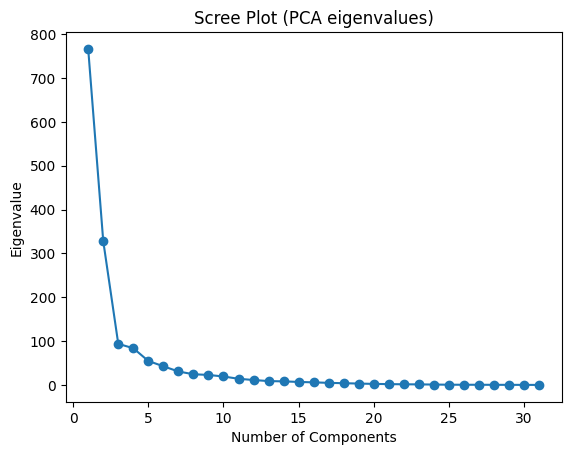

In [22]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [23]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [24]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [25]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1   Factor2   Factor3   Factor4   Factor5
nhw21p                  13.946321  1.345878  0.653982  2.669161 -3.860721
nhb21p                  -5.281053 -6.394498  8.895202 -0.296413  1.681427
h21p                    -7.816748 -2.571533 -5.811013 -2.161545 -2.316717
cvap21bapp              15.901832  6.070533 -3.177223  0.685702  1.080123
log_mhhi21               0.397777  0.244709 -0.235710  0.413359  0.389263
venez21p                -0.356543 -0.189495  0.374142 -0.174095 -0.129725
kor21p                   1.160070  0.671790 -0.259394 -0.649700  0.831758
domin21p                -1.713864 -0.916613 -0.159672 -0.858552 -1.359462
mex21p                  -1.741801  1.369370 -3.373060 -0.555793  0.606957
white_transplant_ratio   5.349341  0.867120  1.726640  2.194933 -0.944471
ind21p                  -0.056767  1.996660 -0.798263  0.329718  0.421901
bang21p                 -2.247279  2.744173  1.085652 -0.204898 -0.332697
fb21bdp             

In [26]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     11.91
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           6.79e-09
Time:                        17:20:25   Log-Likelihood:                -306.17
No. Observations:                  98   AIC:                             624.3
Df Residuals:                      92   BIC:                             639.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1995      0.574     29.980      0.0